In [759]:
# importing relevant libraries
import numpy as np
import pandas as pd
from datetime import timedelta
from datetime import datetime as dt
import pycountry_convert as pc
pd.set_option("display.max_columns", None)
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn import tree
from scipy import stats
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [6]:
# reading in the files
users = pd.read_csv("users.csv")
books = pd.read_csv("books.csv")
bint = pd.read_csv("book_interactions.csv")

## DATA OVERVIEW

In [7]:
# creating a function that displays a brief overview of all the files in this analysis
def overview(file):
    display(file.info())
    display(file.head())
    
    null_count = file.isnull().sum().sort_values(ascending = False)
    per_null_count = round(file.isnull().sum() / file.shape[0] * 100).astype(int).apply(lambda x : str(x) + "%" if x != 0 else "-")
    unique_count = file.nunique(axis = 0)
    per_unique_count = round(file.nunique(axis = 0) / file.shape[0] * 100).astype(int).apply(lambda x : str(x) + "%" if x != 0 else "-")
    
    return pd.concat([null_count, per_null_count, unique_count, per_unique_count], axis = 1, keys = ["null_count", "per_null_count", "unique_count", "per_unique_count"]) 

In [8]:
# displaying the brief overview for each of the files
overview(users)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116231 entries, 0 to 116230
Data columns (total 8 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Unnamed: 0              116231 non-null  int64 
 1   user_id                 116231 non-null  object
 2   signup_at               116231 non-null  object
 3   country                 116231 non-null  object
 4   languages               116231 non-null  object
 5   signup_client_platform  116100 non-null  object
 6   trial_optin_at          21662 non-null   object
 7   purchase_at             10382 non-null   object
dtypes: int64(1), object(7)
memory usage: 7.1+ MB


None

,Unnamed: 0,user_id,signup_at,country,languages,signup_client_platform,trial_optin_at,purchase_at
0,0,61a6bb1ed32d7a000a5f2fec,2021-12-01,es,en,Android,NaN,NaN
1,1,61a6bc6bd32d7a000e314bbd,2021-12-01,us,en,iOS,2021-12-01 00:08:42.907,NaN
2,2,61a6bc9ad32d7a000c26099b,2021-12-01,us,en,iOS,2021-12-01 00:10:15.661,NaN
3,3,61a6bca2d32d7a000b21e2b6,2021-12-01,us,en,iOS,2021-12-01 00:09:30.593,NaN
4,4,61a6bcf7d32d7a000c8f1538,2021-12-01,de,de,Android,2021-12-01 00:11:16.471,NaN


,null_count,per_null_count,unique_count,per_unique_count
purchase_at,105849,91%,10364,9%
trial_optin_at,94569,81%,21482,18%
signup_client_platform,131,-,4,-
Unnamed: 0,0,-,116231,100%
user_id,0,-,116231,100%
signup_at,0,-,14,-
country,0,-,203,-
languages,0,-,3,-


In [9]:
overview(books)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5226 entries, 0 to 5225
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5226 non-null   int64 
 1   book_id     5226 non-null   object
 2   title       5226 non-null   object
 3   author      5226 non-null   object
 4   categories  5226 non-null   object
dtypes: int64(1), object(4)
memory usage: 204.3+ KB


None

,Unnamed: 0,book_id,title,author,categories
0,0,538f34d33761300007360100,Eine neue Version ist verfügbar,Dirk von Gehlen,Technology & the Future
1,1,54c8aed0663337000a2e0000,The End of Power,Moisés Naím,Politics
2,2,55512f536332630007fd0000,Eat That Frog!,Brian Tracy,"Personal Development, Productivity"
3,3,56000223615cd100090000dc,Die Mäusestrategie für Manager,Spencer Johnson,Personal Development
4,4,5681b4aa704a880007000041,The Elements of Scrum,Chris Sims and Hillary Louise Johnson,Management & Leadership


,null_count,per_null_count,unique_count,per_unique_count
Unnamed: 0,0,-,5226,100%
book_id,0,-,5207,100%
title,0,-,5080,97%
author,0,-,3895,75%
categories,0,-,634,12%


In [10]:
overview(bint)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 376619 entries, 0 to 376618
Data columns (total 11 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Unnamed: 0                      376619 non-null  int64  
 1   user_id                         376619 non-null  object 
 2   book_id                         376619 non-null  object 
 3   opened_at                       376619 non-null  object 
 4   opened_from                     375222 non-null  object 
 5   time_spent_in_book_s            376619 non-null  int64  
 6   distinct_chapters_opened_total  376619 non-null  float64
 7   chapter_count                   376619 non-null  int64  
 8   book_started                    376619 non-null  bool   
 9   book_finished                   376619 non-null  bool   
 10  audio_played                    376619 non-null  bool   
dtypes: bool(3), float64(1), int64(3), object(4)
memory usage: 24.1+ MB


None

,Unnamed: 0,user_id,book_id,opened_at,opened_from,time_spent_in_book_s,distinct_chapters_opened_total,chapter_count,book_started,book_finished,audio_played
0,0,61a6bc00d32d7a000dd3dffc,616830ef6cee0700089d6afe,2021-12-01,flex-discover,464,5.0,9,True,False,True
1,1,61a6bd43d32d7a0009f25c25,5be010f06cee07000777c8e1,2021-12-02,flex-discover,2129,12.0,12,True,True,True
2,2,61a6bd43d32d7a0009f25c25,57ba1375ece3ed0003d5ac1b,2021-12-02,flex-discover,213,4.0,12,True,False,True
3,3,61a6bd43d32d7a0009f25c25,571a8bdf8fe3320003ed44a9,2021-12-02,player,512,4.0,13,True,False,True
4,4,61a6bd43d32d7a0009f25c25,571a8bdf8fe3320003ed44a9,2021-12-04,NaN,0,1.0,13,True,False,True


,null_count,per_null_count,unique_count,per_unique_count
opened_from,1397,-,18,-
Unnamed: 0,0,-,376619,100%
user_id,0,-,36235,10%
book_id,0,-,4949,1%
opened_at,0,-,34,-
time_spent_in_book_s,0,-,3424,1%
distinct_chapters_opened_total,0,-,18,-
chapter_count,0,-,14,-
book_started,0,-,2,-
book_finished,0,-,2,-


In [11]:
users

,Unnamed: 0,user_id,signup_at,country,languages,signup_client_platform,trial_optin_at,purchase_at
0,0,61a6bb1ed32d7a000a5f2fec,2021-12-01,es,en,Android,NaN,NaN
1,1,61a6bc6bd32d7a000e314bbd,2021-12-01,us,en,iOS,2021-12-01 00:08:42.907,NaN
2,2,61a6bc9ad32d7a000c26099b,2021-12-01,us,en,iOS,2021-12-01 00:10:15.661,NaN
3,3,61a6bca2d32d7a000b21e2b6,2021-12-01,us,en,iOS,2021-12-01 00:09:30.593,NaN
4,4,61a6bcf7d32d7a000c8f1538,2021-12-01,de,de,Android,2021-12-01 00:11:16.471,NaN
...,...,...,...,...,...,...,...,...
116226,116226,61acaaaed32d7a000c99ef35,2021-12-05,ch,de,NaN,NaN,NaN
116227,116227,61b501b8d32d7a000d500d7a,2021-12-11,de,de,NaN,NaN,NaN
116228,116228,61ae1a0dd32d7a000dc88d4f,2021-12-06,in,en,NaN,NaN,NaN
116229,116229,61abb5d4d32d7a000beea593,2021-12-04,nz,en,NaN,NaN,NaN


## REMOVE IRRELEVANT DATA

In [12]:
# preliminary cleaining the "users" table
users_trial = users[~users["trial_optin_at"].isna()]
users_trial["trial_optin_at"] = pd.to_datetime(users_trial["trial_optin_at"])

# preliminary cleaning of the "bint" table - only include users who participated in the 7 day trial
bint_trial = bint[bint["user_id"].isin(users_trial["user_id"].to_list())]
bint_trial["opened_at"] = pd.to_datetime(bint_trial["opened_at"])

<ipython-input-12-02eb01c18bbe>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  users_trial["trial_optin_at"] = pd.to_datetime(users_trial["trial_optin_at"])
<ipython-input-12-02eb01c18bbe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bint_trial["opened_at"] = pd.to_datetime(bint_trial["opened_at"])


In [13]:
# function to filter out interactions that are not within the trial period
def in_trial_period(row):
    user_id = row["user_id"]
    
    trial_start = users_trial[users_trial["user_id"] == user_id]["trial_optin_at"]
    trial_end = users_trial[users_trial["user_id"] == user_id]["trial_optin_at"] + timedelta(days = 7)
    
    if trial_start.values <= row["opened_at"] <= trial_end.values:
        return True
    else:
        return False

In [14]:
# creating a new column "in_trial" to label interactions as either being in within the 7 day trial period or not
bint_trial["in_trial"] = bint_trial.apply(in_trial_period, axis = 1)

<ipython-input-14-1a3cc6d0fbd6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bint_trial["in_trial"] = bint_trial.apply(in_trial_period, axis = 1)


In [15]:
# only including records that occured in the 7 day trial period
bint_trial = bint_trial[bint_trial["in_trial"] == True]

In [104]:
# so now we filtered the the user and bint tables for records that are within the 7 day trial period
# and they are now stored in the "users_trial" & "bint_trial" variables

In [16]:
# removing the "Unnamed: 0" column from the "users_trial" & "bint_trial" tables
users_trial.drop("Unnamed: 0", axis =1, inplace = True)
bint_trial.drop("Unnamed: 0", axis = 1, inplace = True)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [17]:
# remove the "Unnamed : 0" column from the books table
books.drop("Unnamed: 0", axis = 1, inplace = True)

## DEDUPLICATE TABLES

In [18]:
# identifying duplicates rows
users_duplicates = users_trial[~users_trial.duplicated()]
bint_duplicates = bint_trial[bint_trial.duplicated()]
books_duplicates = books[books.duplicated()]

In [19]:
# showing which tables have duplicate values
display(users_duplicates)
display(bint_duplicates)
display(books_duplicates)

,user_id,signup_at,country,languages,signup_client_platform,trial_optin_at,purchase_at
1,61a6bc6bd32d7a000e314bbd,2021-12-01,us,en,iOS,2021-12-01 00:08:42.907,NaN
2,61a6bc9ad32d7a000c26099b,2021-12-01,us,en,iOS,2021-12-01 00:10:15.661,NaN
3,61a6bca2d32d7a000b21e2b6,2021-12-01,us,en,iOS,2021-12-01 00:09:30.593,NaN
4,61a6bcf7d32d7a000c8f1538,2021-12-01,de,de,Android,2021-12-01 00:11:16.471,NaN
5,61a6be78d32d7a000b2c7f5c,2021-12-01,us,en,iOS,2021-12-01 00:15:42.627,NaN
...,...,...,...,...,...,...,...
116194,61b924e9d32d7a000e78c36a,2021-12-14,us,en,Android,2021-12-14 23:15:46.387,2021-12-21 22:19:57.000
116197,61b9261cd32d7a000e78c3c1,2021-12-14,se,en,iOS,2021-12-14 23:23:22.700,NaN
116216,61b92e41d32d7a000f829dbd,2021-12-14,ru,en,Android,2021-12-14 23:58:49.443,NaN
116221,61b92f75d32d7a000c45db7c,2021-12-14,de,"de,en",iOS,2021-12-15 00:01:12.505,NaN


,user_id,book_id,opened_at,opened_from,time_spent_in_book_s,distinct_chapters_opened_total,chapter_count,book_started,book_finished,audio_played,in_trial
95,61a6c7b0d32d7a000b21e491,5ea32d376cee070006684271,2021-12-04,player,1635,9.0,9,True,True,True,True
275,61a70d0fd32d7a000b21f05d,5aba3a77b238e100066bfcad,2021-12-02,player,1095,8.0,15,True,False,True,True
283,61a70d0fd32d7a000b21f05d,5aba3a77b238e100066bfcad,2021-12-03,player,1288,8.0,15,False,True,True,True
288,61a70d0fd32d7a000b21f05d,60b11a806cee07000751a51e,2021-12-03,player,1938,11.0,11,True,True,True,True
1244,61a7abced32d7a000b5c7cbd,619e3bb96cee0700089455c8,2021-12-05,library,0,1.0,9,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...
376104,61b8b30ad32d7a000b58de86,59356118b238e100051fdabb,2021-12-19,player,3,1.0,11,True,False,True,True
376343,61b8db9bd32d7a000f8283e4,55102237666564000a630000,2021-12-19,player,35,1.0,11,False,True,True,True
376348,61b8db9bd32d7a000f8283e4,55102237666564000a630000,2021-12-19,player,1271,11.0,11,True,True,True,True
376481,61b8fc05d32d7a000bedf9e9,59356118b238e100051fdabb,2021-12-17,player,0,1.0,11,True,False,True,True


,book_id,title,author,categories
2184,5f8f0f996cee0700070383e0,Boris Johnson,Jan Roß,"Biography & Memoir, Politics"
2363,5a8c256bb238e100074317bb,Adaptive Markets,Andrew W. Lo,Economics
2519,55102237666564000a630000,The Sales Bible,Jeffrey Gitomer,Marketing & Sales
2587,5eac82386cee070006f0469f,Scale,Geoffrey West,"Economics, Nature & the Environment, Science"
3227,55ed4db711ad1a0009000089,The Sixth Extinction,Elizabeth Kolbert,"Nature & the Environment, Science"
3345,602bca2f6cee07000876e8e4,Happy Money,Ken Honda,Money & Investments
3504,5e8393b06cee07000645a42a,Abschied vom Abstieg,Herfried Münkler & Marina Münkler,"Education, Politics"
3606,5df8d8806cee070008c0014f,Unleashing the Ideavirus,Seth Godin,Marketing & Sales
3645,5e904a266cee0700061cc535,Bildung,Jan Roß,"Education, Philosophy"
3816,59356118b238e100051fdabb,Homo Deus,Yuval Noah Harari,"Science, Technology & the Future"


In [20]:
# removing duplicate rows from the tables
users_trial = users_trial[~users_trial.duplicated()]
bint_trial = bint_trial[~bint_trial.duplicated()]
books = books[~books.duplicated()]

## FIX STRUCTURAL ERRORS

### USERS TABLE

In [21]:
# seperating the languages column into "english" & "german"
users_trial["english"] = users_trial.apply(lambda x: 1 if "en" in x["languages"] else 0, axis = 1)
users_trial["german"] = users_trial.apply(lambda x: 1 if "de" in x["languages"] else 0, axis = 1)

In [22]:
# dropping the languages column
users_trial.drop("languages", axis = 1, inplace = True)

In [23]:
# converting column datatypes
users_trial["signup_at"] = pd.to_datetime(users_trial["signup_at"])
users_trial["purchase_at"] = pd.to_datetime(users_trial["purchase_at"])

### BINT TABLE

In [24]:
# converting T/F values to 0s and 1s
bint_trial["book_started"] = bint_trial["book_started"].astype(int)
bint_trial["book_finished"] = bint_trial["book_finished"].astype(int)
bint_trial["audio_played"] = bint_trial["audio_played"].astype(int)

In [25]:
# dropping "in_trial" column that we created earlier to filter out rows that were not in the 7 day trial
bint_trial.drop("in_trial", axis = 1, inplace = True)

## IMPUTING VALUES

### USERS_TRIAL

In [26]:
# converting "purchase_at" column to 0s and 1s
users_trial["purchase_at"] = users_trial["purchase_at"].apply(lambda x: 0 if str(x) == "NaT" else 1)

In [27]:
# imputing the null values in the "signup_client_platform" column with the mode
users_trial["signup_client_platform"] = users_trial["signup_client_platform"].fillna(users_trial["signup_client_platform"].value_counts().index[0])

### BINT_TRIAL

In [28]:
# creating a function to impute missing values in the "opened_from" column
def imputer(row):
    user_id = row["user_id"]
    
    user_data = bint_trial[bint_trial["user_id"] == user_id]
    
    opened_from_pop = user_data["opened_from"].value_counts().index
    
    if str(row["opened_from"]) == "nan":
        if len(opened_from_pop) > 0:
            return opened_from_pop[0]
        else:
            return np.nan
    else:
        return row["opened_from"]

In [29]:
# imputing values in the "opened_from" column using the above function
bint_trial["opened_from"] = bint_trial.apply(imputer, axis = 1)

In [30]:
# imputting the remaining values null values in "opened_from" with the most common value
bint_trial["opened_from"] = bint_trial["opened_from"].fillna(bint_trial["opened_from"].value_counts().index[0])

## ADDING GROUP 1 & GROUP 2
- Group 1 = users that started books on at least 2 different days during their trial
- Group 2 = users that did NOT started books on at least 2 different days during their trial

In [31]:
# filtering out user_ids from the users_trial table that are not in the bint_trial table
users_trial = users_trial[users_trial["user_id"].isin(bint_trial["user_id"].unique())]

In [32]:
# it might be better to group the data before
seperate_days = pd.DataFrame(bint_trial.groupby(["user_id", "opened_at"])["opened_at"].count())

# function that labels a users as either being part of group 1 or group 2
def group_class(row):
    user_id = row["user_id"]
    
    count = seperate_days.loc[user_id, "opened_at"].shape[0]
    
    if count >= 2:
        return "group_1"
    else:
        return "group_2"

In [33]:
# categorizing a user as either being part of "group_1" or "group_2"
users_trial["group"] = users_trial.apply(group_class, axis = 1)

## MERGING TABLES TOGETHER

In [34]:
# merging the "users_trial" & "bint_trial" tables together
combined = pd.merge(left = users_trial, right = bint_trial, on = "user_id", how = "inner")

In [35]:
# merging the the "books" table with the "combined" table
combined = pd.merge(left = combined, right = books, on = "book_id", how = "inner")

## SPLITTING INTO 2 GROUPS

In [ ]:
# remember that each row represents a unique row interaction

In [36]:
# splitting the data into group 1 & group 2
group_1 = combined[combined["group"] == "group_1"]
group_2 = combined[combined["group"] == "group_2"]

In [37]:
# calculating the percent of users who subscirbed witin the 7 day trial for both groups
unique_subscribers_g1 = round((group_1[~group_1.duplicated("user_id")]["purchase_at"].sum() /
                      len(group_1["user_id"].unique())) * 100)
unique_subscribers_g2 = round((group_2[~group_2.duplicated("user_id")]["purchase_at"].sum() /
                      len(group_2["user_id"].unique())) * 100)

print("group 1 percent of users who subscribed within 7 day trial = ", unique_subscribers_g1, "%")
print("group 2 percent of users who subscribed within 7 day trial = ", unique_subscribers_g2, "%")

group 1 percent of users who subscribed within 7 day trial =  56 %
group 2 percent of users who subscribed within 7 day trial =  40 %


## EXPLORATORY DATA ANALYSIS

In [932]:
# creating a function that graphs our findings 
def grapher(g1, g2, combined, col_name, part_2 = False):

    plot_3 = pd.merge(left = g1, right = combined, left_index = True, right_index = True, how = "inner")
    plot_3["diff"] = plot_3.iloc[:, 0] - plot_3.iloc[:, 1]

    plot_4 = pd.merge(left = g2, right = combined, left_index = True, right_index = True, how = "inner")
    plot_4["diff"] = plot_4.iloc[:, 0] - plot_4.iloc[:, 1]
    
    
    if part_2:
    
        fig = make_subplots(rows = 2,
                            cols = 2,
                            specs = [[{"type": "pie"}, {"type": "pie"}], [{"type": "bar"}, {"type": "bar"}]],
                            subplot_titles = ("Distribution of Group 1 <br> ".format(), "Distribution of Group 2 <br> ",
                                              "Proportional Difference of Group 1 <br> ", "Proportional Difference of Group 2 <br> "),
                            horizontal_spacing = 0.12)

        fig.add_trace(go.Pie(labels = g1.index.to_list(),
                             values = g1[col_name].to_list()),
                             row = 1,
                             col = 1)

        fig.add_trace(go.Pie(labels = g2.index.to_list(),
                             values = g2[col_name].to_list()),
                             row = 1,
                             col = 2)

        fig.add_trace(go.Bar(x = plot_3.index,
                             y = plot_3["diff"],
                             name = "diff",
                             textposition = "auto"),
                             row = 2,
                             col = 1)

        fig.add_trace(go.Bar(x = plot_4.index,
                             y = plot_4["diff"],
                             name = "diff",
                             textposition = "auto"),
                             row = 2,
                             col = 2)

        fig.update_traces(marker_line_color = "rgb(8,48,107)", marker_line_width = 1.5, row = 1, col = 1)
        fig.update_traces(marker_line_color = "rgb(8,48,107)", marker_line_width = 1.5, row = 1, col = 2)
        fig.update_traces(marker_line_color = "rgb(8,48,107)", marker_line_width = 1.5, row = 2, col = 1)
        fig.update_traces(marker_line_color = "rgb(8,48,107)", marker_line_width = 1.5, row = 2, col = 2)

        fig.update_yaxes(title_text = "Proportional Difference", showgrid = False, showticklabels = False, row = 2, col = 1)
        fig.update_yaxes(title_text = "Proportional Difference", showgrid = False, showticklabels = False, row = 2, col = 2)

    else:
        
        fig = make_subplots(rows = 1,
                            cols = 2,
                            specs = [[{"type": "pie"}, {"type": "pie"}]],
                            subplot_titles = ("Distribution of Group 1 <br> ".format(), "Distribution of Group 2 <br> "),
                            horizontal_spacing = 0.12)

        fig.add_trace(go.Pie(labels = g1.index.to_list(),
                             values = g1[col_name].to_list()),
                             row = 1,
                             col = 1)

        fig.add_trace(go.Pie(labels = g2.index.to_list(),
                             values = g2[col_name].to_list()),
                             row = 1,
                             col = 2)
        
        fig.update_traces(marker_line_color = "rgb(8,48,107)", marker_line_width = 1.5, row = 1, col = 1)
        fig.update_traces(marker_line_color = "rgb(8,48,107)", marker_line_width = 1.5, row = 1, col = 2)
        
    fig.show()

# for graphing bin data
def grapher_2(g1, g2, col_name):

    fig = make_subplots(rows = 2,
                        cols = 1,
                        subplot_titles = ("Distribution of Group 1 <br> ", "Distribution of Group 2 <br> "),
                        horizontal_spacing = 0.9)

    fig.add_trace(go.Bar(x = g1.index.to_list(),
                                 y = g1[col_name].to_list()),
                                 row = 1,
                                 col = 1)

    fig.add_trace(go.Bar(x = g2.index.to_list(),
                                 y = g2[col_name].to_list()),
                                 row = 2,
                                 col = 1)
    
    fig.update_traces(marker_line_color = "rgb(8,48,107)", marker_line_width = 1.5, row = 1, col = 1)
    fig.update_traces(marker_line_color = "rgb(8,48,107)", marker_line_width = 1.5, row = 2, col = 1)
    
    fig.update_yaxes(showgrid = False, showticklabels = False, row = 1, col = 1)
    fig.update_yaxes(showgrid = False, showticklabels = False, row = 2, col = 1)

    fig.show()



#### How many different books users interacted with before commiting to a subscription?

In [823]:
# creating copies of our group data
q1_g1 = group_1.copy()
q1_g2 = group_2.copy()
q1_combined = combined.copy()

# creating a function that shows output the value_counts for the number of differnt books users interact with beofre subscribing
def subscribed_users_diff_books(df, combined = False):
    purchase = df[df["purchase_at"] == 1]
    unique_books_users = pd.DataFrame(purchase.groupby("user_id")["book_id"].nunique())
    unique_books_users["book_id"] = unique_books_users["book_id"].astype(str) + " books"
    
    if combined:
        return pd.DataFrame(unique_books_users["book_id"].value_counts(normalize = True) * 100)
    else:
        return pd.DataFrame(unique_books_users["book_id"].value_counts(normalize = True)[:5] * 100)

# gathering data
g1_sub_books = subscribed_users_diff_books(q1_g1)
g2_sub_books = subscribed_users_diff_books(q1_g2)
combined_sub_books = subscribed_users_diff_books(q1_combined, combined = True)


# graphing data
grapher(g1_sub_books, g2_sub_books, combined_sub_books, "book_id", part_2 = True)



#### How do the holidays effect affect subscriptions?

In [824]:
# creating copies of our group data
q2_g1 = group_1.copy()
q2_g2 = group_2.copy()
q2_combined = combined.copy()

# creating a function that counts the number of users who became subscribers and had a book interaction on a holiday day
def holiday_counter(df):
    df_subs = df[df["purchase_at"] == 1]
    users = pd.DataFrame(df_subs["user_id"].unique())
    
    christmas_eve = 0
    christmas_day = 0
    new_years_eve = 0
    new_years_day = 0
    
    for user in users.values:
        user_data = df_subs[df_subs["user_id"] == user[0]]
        
        unqiue_dates = set([str(x)[5:10] for x in user_data["opened_at"]])
        
        if "12-24" in unqiue_dates:
            christmas_eve += 1
        if "12-25" in unqiue_dates:
            christmas_day += 1
        if "12-31" in unqiue_dates:
            new_years_eve += 1
        if "01-01" in unqiue_dates:
            new_years_day += 1
                
            
    
    total = pd.DataFrame(pd.Series([christmas_eve, christmas_day, new_years_eve, new_years_day]))
    total.index = ["christmas_eve", "christmas_day", "new_years_eve", "new_years_day"]
    total.columns = ["holiday"]
    return total

# Gathering the data 
holiday_g1 = (holiday_counter(q2_g1) / q2_g1.shape[0]) * 100
holiday_g2 = (holiday_counter(q2_g2) / q2_g2.shape[0]) * 100
holiday_combined = (holiday_counter(q2_combined) / q2_combined.shape[0]) * 100

grapher(holiday_g1, holiday_g2, holiday_combined, "holiday", part_2 = True)


#### Do more diverse books (books that are part of more than 1 category) perform bettr in terms of # of subscriptions?
the purpose of this question is to quantify how much each category contributed towards subscriptions

In [833]:
# creating copies of our group data
q3_g1 = group_1.copy()
q3_g2 = group_2.copy()
q3_combined = combined.copy()

# function that calculates the contribution of each category to subscribing users
def cat_contributor_calc(df):
    df_subs = df[df["purchase_at"] == 1]
    users = pd.DataFrame(df_subs["user_id"].unique())
    cat_per_contribution = {}

    for user in users.values:
        user_data = df_subs[df_subs["user_id"] == user[0]]
    
        cats = []
    
        for category in user_data["categories"].values:
            diff_cat = category.split(",")
            diff_cat = [x.strip() for x in diff_cat]
            cats.extend(diff_cat)
    
    
        cats_df = pd.DataFrame(cats)
        contributions = pd.DataFrame(cats_df.value_counts(normalize = True)) * 100
        contributions["cats"] = contributions.index
        contributions["cats"] = contributions["cats"].astype(str)
        contributions["cats"] = contributions["cats"].str.replace("(", "").str.replace(")", "").str.replace(",", "").str.replace("'", "")
        contributions.columns = ["percent", "cat"]
    
        for index, row in contributions.iterrows():
            cat = (row["cat"])
            percent = (row["percent"])
        
            if cat in cat_per_contribution:
                cat_per_contribution[cat] += percent
            else:
                cat_per_contribution[cat] = percent
                
    data = {k: v / users.shape[0] for k,v in cat_per_contribution.items()}
    df = pd.DataFrame.from_dict(data, orient = "index")
    df.columns = ["freq"]
    df = df.sort_values("freq", ascending = False)[:5]
    return df

# gathering the data
cat_cont_g1 = cat_contributor_calc(q3_g1)
cat_cont_g2 = cat_contributor_calc(q3_g2)
cat_cont_combined = cat_contributor_calc(q3_combined)

# graphing the data
grapher(cat_cont_g1, cat_cont_g2, cat_cont_combined, "freq", part_2 = True)


#### Look at the ratio of "distinct_chapters_opened_total" to "chapter_count"
this will tell us how much a book was completed before someone decide to subscribe - and then we can bin it so that we can have intervals

In [984]:
# creating copies of our group data
q4_g1 = group_1.copy()
q4_g2 = group_2.copy()
q4_combined = combined.copy()

# creating a function to see the average percent of completing a book for each user before they subscribe
def book_completeness(df):
    df_subs = df[df["purchase_at"] == 1]
    users = pd.DataFrame(df_subs["user_id"].unique())
    user_avg_completeness = {}

    for user in users.values:
        user_data = df_subs[df_subs["user_id"] == user[0]]
        user_data["per_book_complete"] = user_data["distinct_chapters_opened_total"] / user_data["chapter_count"]
        avg_completeness = user_data["per_book_complete"].mean()
        user_avg_completeness[user[0]] = avg_completeness

    df_final = pd.DataFrame.from_dict(user_avg_completeness, orient ='index')
    df_final.columns = ["percent_complete"]
    
    df_final = pd.DataFrame(df_final["percent_complete"].value_counts(bins = 10).sort_index())
    df_final.columns = ["percent_complete"]
    
    new_index = [str(round(float(str(index).split(",")[0][1:]), 2) * 100)+"-"
             + str(round(float(str(index).split(",")[1].strip().rstrip("]")), 2) * 100)
          for index in df_final.index]
    
    df_final.index = new_index
    
    
    return df_final

percent_complete_q4_g1 = book_completeness(q4_g1)
percent_complete_q4_g2 = book_completeness(q4_g2)
percent_complete_combined = book_completeness(q4_combined)

# graphing the data
grapher_2(percent_complete_q4_g1, percent_complete_q4_g2, "percent_complete")

#### Looking at the average time spent in a book
similar question to the one above, but this time, we are interested in seeing the average time spent on a book beofre commiting to a subscription

In [1024]:
# creating copies of our group data
q5_g1 = group_1.copy()
q5_g2 = group_2.copy()
q5_combined = combined.copy()

# creating a function to output the avg time in minutes spent on a book before subscribing
def avg_book_time(df):
    df_subs = df[df["purchase_at"] == 1]
    users = pd.DataFrame(df_subs["user_id"].unique())
    user_avg_book_time = {}

    for user in users.values:
        user_data = df_subs[df_subs["user_id"] == user[0]]
        user_data["avg_book_time"] = (user_data["time_spent_in_book_s"] / 60) / user_data["distinct_chapters_opened_total"]
        avg_book_time = user_data["avg_book_time"].mean()
        user_avg_book_time[user[0]] = avg_book_time

    df_final = pd.DataFrame.from_dict(user_avg_book_time, orient ='index')
    df_final.columns = ["avg_book_time"]
    
    df_final = pd.DataFrame(df_final["avg_book_time"].value_counts(bins = 10).sort_index())
    df_final.columns = ["avg_book_time"]
    
    new_index = [str(round(float(str(index).split(",")[0][1:]), 2))+"-"
             + str(round(float(str(index).split(",")[1].strip().rstrip("]")), 2))
          for index in df_final.index]
    
    df_final.index = new_index
    
    return df_final

# gathering the data
avg_book_time_q5_g1 = avg_book_time(q5_g1)
avg_book_time_q5_g2 = avg_book_time(q5_g2)
avg_book_time_combined = avg_book_time(combined)

# graphing the data
grapher_2(avg_book_time_q5_g1, avg_book_time_q5_g2, "avg_book_time")


#### Looking at the average number of chapters read before commiting to a subscription

In [1025]:
# creating copies of our group data
q6_g1 = group_1.copy()
q6_g2 = group_2.copy()
q6_combined = combined.copy()

# creating a function that shows the avg. number of chapters a user reads before commiting to subscription
def avg_distinct_chap(df):
    df_subs = df[df["purchase_at"] == 1]
    users = pd.DataFrame(df_subs["user_id"].unique())
    user_avg_distinct_chap = {}

    for user in users.values:
        user_data = df_subs[df_subs["user_id"] == user[0]]
        avg_distinct_chap = user_data["distinct_chapters_opened_total"].mean()
        user_avg_distinct_chap[user[0]] = avg_distinct_chap

    df_final = pd.DataFrame.from_dict(user_avg_distinct_chap, orient ='index')
    df_final.columns = ["avg_distinct_chap"]
    
    df_final = pd.DataFrame(df_final["avg_distinct_chap"].value_counts(bins = 10).sort_index())
    df_final.columns = ["avg_distinct_chap"]
    
    new_index = [str(round(float(str(index).split(",")[0][1:]), 2))+"-"
             + str(round(float(str(index).split(",")[1].strip().rstrip("]")), 2))
          for index in df_final.index]
    
    df_final.index = new_index
    
    return df_final

# gathering the data
avg_distinct_chap_q6_g1 = avg_distinct_chap(q6_g1)
avg_distinct_chap_q6_g2 = avg_distinct_chap(q6_g2)
avg_distinct_chap_combined = avg_distinct_chap(combined)

# graphing the data
grapher_2(avg_distinct_chap_q6_g1, avg_distinct_chap_q6_g2, "avg_distinct_chap")


#### Looking at the percentage of "uniteresting_books" that makes up a users book selection 
this tells us how well some of the users belive in their product

In [1026]:
# creating copies of our group data
q7_g1 = group_1.copy()
q7_g2 = group_2.copy()
q7_combined = combined.copy()

# creating a function to see the percent of uniterested books that make up their books selection beofre commiting to a subscription
def percent_uninterested(df):
    df_subs = df[df["purchase_at"] == 1]
    users = pd.DataFrame(df_subs["user_id"].unique())

    user_uninterested_book_per = {}

    for user in users.values:
        user_data = df_subs[df_subs["user_id"] == user[0]]

        user_data = user_data.sort_values("time_spent_in_book_s", ascending = False)

        num_books = user_data["title"].nunique()

        uninterested = user_data[(df["time_spent_in_book_s"] < 20) &
                     (df["purchase_at"] == 1) &
                     (df["distinct_chapters_opened_total"] == 1) &
                     (df["audio_played"] == 0)]

        uninterested = uninterested.drop_duplicates("book_id", keep = "first")
        uniterested_book_count = uninterested.shape[0]
        per_uninterested = uniterested_book_count / num_books
        user_uninterested_book_per[user[0]] = per_uninterested

    df_final = pd.DataFrame.from_dict(user_uninterested_book_per, orient ='index')
    df_final.columns = ["per_uninterested"]
    
    
    df_final = pd.DataFrame(df_final["per_uninterested"].value_counts(bins = 10).sort_index())
    df_final.columns = ["per_uninterested"]
    
    new_index = [str(round(float(str(index).split(",")[0][1:]), 2))+"-"
             + str(round(float(str(index).split(",")[1].strip().rstrip("]")), 2))
          for index in df_final.index]
    
    df_final.index = new_index
    
    return df_final
    
# gathering the data
uninterested_q7_g1 = percent_uninterested(q7_g1)
uninterested_q7_g2 = percent_uninterested(q7_g2)
uninterested_q7_combined = percent_uninterested(q7_combined)

# graphing the data
grapher_2(uninterested_q7_g1, uninterested_q7_g2, "per_uninterested")



#### After how many different books does a user turn into a subscriber?

In [1027]:
# creating copies of our group data
q8_g1 = group_1.copy()
q8_g2 = group_2.copy()
q8_combined = combined.copy()

# creating a function to output the number of differnt books a user reads before commiting to a subscription
def num_books(df):
    df_subs = df[df["purchase_at"] == 1]
    users = pd.DataFrame(df_subs["user_id"].unique())

    user_book_count = {}

    for user in users.values:
        user_data = df_subs[df_subs["user_id"] == user[0]]

        num_books = user_data["book_id"].nunique()

        user_book_count[user[0]] = num_books

    df_final = pd.DataFrame.from_dict(user_book_count, orient ='index')
    df_final.columns = ["num_books"]
    
    df_final = pd.DataFrame(df_final["num_books"].value_counts(bins = 10).sort_index())
    df_final.columns = ["num_books"]
    
    new_index = [str(round(float(str(index).split(",")[0][1:]), 2))+"-"
             + str(round(float(str(index).split(",")[1].strip().rstrip("]")), 2))
          for index in df_final.index]
    
    df_final.index = new_index
    
    return df_final

# gathering the data =
num_books_q8_g1 = num_books(q8_g1)
num_books_q8_g2 = num_books(q8_g2)
num_books_combined = num_books(q8_combined)

# graphing the data
grapher_2(num_books_q8_g1, num_books_q8_g2, "num_books")


#### Are bilingual users more likely to end up as subscribers?

In [1031]:
# creating copies of our group data
q9_g1 = group_1.copy()
q9_g2 = group_2.copy()
q9_combined = combined.copy()

# creating a function to output the number of subscribing users for each language
def language_dist(df):
    purchased = df[df["purchase_at"] == 1]

    purchased = purchased.drop_duplicates("user_id")

    english = (purchased["english"].sum() / purchased.shape[0])* 100
    german = (purchased["german"].sum() / purchased.shape[0]) * 100
    both = (purchased[(purchased["english"] == 1) & (purchased["german"] == 1)].shape[0] / purchased.shape[0]) * 100
    
    series = pd.Series([english, german, both])
    series.index = ["english", "german", "both"]
    
    series = pd.DataFrame(series)
    series.columns = ["freq"]
    
    return series

# gathering the data
languages_q9_g1 = language_dist(q9_g1)
languages_q9_g2 = language_dist(q9_g2)
languages_combined = language_dist(q9_combined)

# graphing the data
grapher(languages_q9_g1, languages_q9_g2, languages_combined, "freq", part_2 = True)


#### Which "sign_up_client_platform" do most users sign_up from?

In [939]:
# creating copies of our group data
q10_g1 = group_1.copy()
q10_g2 = group_2.copy()
q10_combined = combined.copy()

# creating a function to output the distribution of sign-up platforms for subscribing users
def platform_dist(df):
    purchased = df[df["purchase_at"] == 1]

    purchased = purchased.drop_duplicates("user_id")
    
    df = purchased["signup_client_platform"].value_counts(normalize = True)
    df = pd.DataFrame(df)
    df.columns = ["freq"]
    
    return df
    
# gathering the data
user_platform_q10_g1 = platform_dist(q10_g1)
user_platform_q10_g2 = platform_dist(q10_g2) 
user_platform_combined = platform_dist(q10_combined)

# graphing the data
grapher(user_platform_q10_g1, user_platform_q10_g2, user_platform_combined, "freq", part_2 = True)


#### What percentage of books do subscribers complete?

In [1030]:
# creating copies of our group data
q11_g1 = group_1.copy()
q11_g2 = group_2.copy()
q11_combined = combined.copy()

# creating a function to output the percentage of finished and unfinished books per subscribing user
def finished_unfinished_books(df):
    df_subs = df[df["purchase_at"] == 1]
    users = pd.DataFrame(df_subs["user_id"].unique())

    read_split = {}

    for user in users.values:
        user_data = df_subs[df_subs["user_id"] == user[0]]
        split = user_data.groupby("book_id")["book_finished"].sum().astype(bool).value_counts(normalize = True).sort_index().to_list()
        read_split[user[0]] = split
    
    df_final = pd.DataFrame.from_dict(read_split, orient ='index')
    df_final.columns = ["unfinished", "finished"]
    
    df_final = df_final["unfinished"]
    
    df_final = pd.DataFrame(df_final)
    
    df_final.columns = ["unfinished"]
    
    df_final = df_final["unfinished"].value_counts(bins = 10).sort_index()
    
    df_final = pd.DataFrame(df_final)
    
    df_final.columns = ["unfinished"]
    
    new_index = [str(round(float(str(index).split(",")[0][1:]), 2))+"-"
             + str(round(float(str(index).split(",")[1].strip().rstrip("]")), 2))
          for index in df_final.index]
    
    df_final.index = new_index
    
    return df_final

# gathering the data
fin_unfin_q11_g1 = finished_unfinished_books(q11_g1)
fin_unfin_q11_g2 = finished_unfinished_books(q11_g2)
fin_unfin_combined = finished_unfinished_books(q11_combined)

# graphing the data
grapher_2(fin_unfin_q11_g1, fin_unfin_q11_g2, "unfinished")


#### Does listening to audio increase the subscription likelihood?
for those who subsribed, what percentenage of books were listened to

In [1028]:
# creating copies of our group data
q12_g1 = group_1.copy()
q12_g2 = group_2.copy()
q12_combined = combined.copy()

# creating a function to output the percentage of books that were listened to and not listened to per subscribing user
def listen_audio(df):
    df_subs = df[df["purchase_at"] == 1]
    users = pd.DataFrame(df_subs["user_id"].unique())

    audio_split = {}

    for user in users.values:
        user_data = df_subs[df_subs["user_id"] == user[0]]
        split = user_data.groupby("book_id")["audio_played"].sum().astype(bool).value_counts(normalize = True).sort_index().to_list()
        audio_split[user[0]] = split
    
    df_final = pd.DataFrame.from_dict(audio_split, orient ='index')
    df_final.columns = ["no_audio", "audio"]
    
    df_final = df_final.fillna(0)
    
    df_final = df_final["audio"]
    
    df_final = pd.DataFrame(df_final)
    
    df_final.columns = ["audio"]
    
    df_final = df_final["audio"].value_counts(bins = 10).sort_index()
    
    df_final = pd.DataFrame(df_final)
    
    df_final.columns = ["audio"]
    
    new_index = [str(round(float(str(index).split(",")[0][1:]), 2))+"-"
             + str(round(float(str(index).split(",")[1].strip().rstrip("]")), 2))
          for index in df_final.index]
    
    df_final.index = new_index
    
    return df_final

# gathering the data
audio_q12_g1 = listen_audio(q12_g1)
audio_q12_g2 = listen_audio(q12_g2)
audio_combined = listen_audio(q12_combined)

# graphing the data
grapher_2(audio_q12_g1, audio_q12_g2, "audio")


#### What are top book categories in each region?

In [1029]:
# creating copies of our group data
q13_g1 = group_1.copy()
q13_g2 = group_2.copy()
q13_combined = combined.copy()

# creating a function that outputs the frequency of categories in each region
def region_cat(df):
    
    total_cats = []
    
    for cat in df["categories"].str.split(","):
        total_cats.extend(cat)
    
    all_cats = pd.DataFrame(pd.Series(total_cats).str.strip().value_counts())
    all_cats = all_cats.drop(0, axis = 1)

    df["region"] = df["country"].apply(lambda x: pc.country_alpha2_to_continent_code(x.upper()))

    for region in df["region"].unique():

        cats = []

        region_data = df[df["region"] == region]

        region_data = region_data.drop_duplicates(["user_id", "book_id"], keep = "first")

        for cat in region_data["categories"].str.split(","):
            cats.extend(cat)

        region = pd.DataFrame(pd.Series(cats).str.strip().value_counts())

        all_cats = pd.merge(left = all_cats, right = region, left_index = True, right_index = True, how = "left")
    


    all_cats.columns = ["EU", "AS", "SA", "NA", "AF", "OC"]
    
    return all_cats

region_cat_q13_g1 = region_cat(q13_g1)
region_cat_q13_g2 = region_cat(q13_g2)
region_cat_combined = region_cat(q13_combined)

# graphing the data
fig = px.bar(region_cat_q13_g1, x = region_cat_q13_g1.index, y = ["EU", "AS", "SA", "NA", "AF", "OC"], title = "Distribution of Categories for Group 1 Across Regions")
fig.show()

fig = px.bar(region_cat_q13_g2, x = region_cat_q13_g2.index, y = ["EU", "AS", "SA", "NA", "AF", "OC"], title = "Distribution of Categories for Group 2 Across Regions")
fig.show()

#### What is the subsciption difference between those who sign up & start trial on the same day vs. those who sign up and start trial on different days?

In [1016]:
# creating copies of our group data
q14_g1 = group_1.copy()
q14_g2 = group_2.copy()
q14_combined = combined.copy()

# creating a function to output the diffence between subscription outcomes between same-day sign-up-trial & diff-day-trial combinations
def same_diff_day(df):

    df["same_day"] = df["signup_at"].dt.date == df["trial_optin_at"].dt.date

    same_day = df[df["same_day"] == True]
    not_same_day = df[df["same_day"] == False]

    same_day = same_day.drop_duplicates("user_id", keep = "first")

    same_day_per = same_day["purchase_at"].value_counts(normalize = True)

    not_same_day = not_same_day.drop_duplicates("user_id", keep = "first")

    not_same_day_per = not_same_day["purchase_at"].value_counts(normalize = True)

    merged = pd.merge(left = same_day_per, right = not_same_day_per, left_index = True, right_index = True)

    merged.columns = ["same_day", "diff_day"]

    return merged

same_diff_day_q14_g1 = same_diff_day(q14_g1) * 100
same_diff_day_q14_g2 = same_diff_day(q14_g2) * 100
same_diff_day_combined = same_diff_day(q14_combined) * 100

# graphing the data
for data_table in [same_diff_day_q14_g1, same_diff_day_q14_g2, same_diff_day_combined]:

    fig = go.Figure(data = [go.Table(
        header = dict(values = list(same_diff_day_q14_g1.columns),
                     fill_color = "paleturquoise",
                     align = "left"),
        cells = dict(values = [same_diff_day_q14_g1["same_day"], same_diff_day_q14_g1["diff_day"]],
                     fill_color = "lavender",
                     align = "left"))
            ])
    
    fig.update_layout(
                  height = 120,
                  margin = dict(r = 0, l = 0, t = 40, b = 0))

    fig.show()

## FEATURE ANALYSIS

### EVALUATING THE PERFORMANCE OF CERTAIN FEATURES

In [1023]:
# copying the combined dataframe into new variable
feature_eval = combined.copy()

# assiging each interaction/book one category to simplify the analysis
feature_eval["categories"] = feature_eval["categories"].str.split(",").str[0]

# creating a function that measures the performance of features against the dataset avergages - either over or under performin comapred to the dataset averages
def stats_comparison(i):
    feature_eval.groupby(i)["purchase_at"].agg(avg = "mean", subscribers = "count").reset_index()
    cat = feature_eval.groupby(i)["purchase_at"].agg(sub_avg = "mean", sub_subscribers = "count").reset_index()
    cat["overall_average"] = tester["purchase_at"].mean()
    cat["overall_subscribers"] = tester["purchase_at"].count()
    cat["rest_subscribers"] = cat["overall_subscribers"] - cat["sub_subscribers"]
    cat["rest_average"] = (cat["overall_subscribers"] * cat["overall_average"] - cat["sub_subscribers"] * cat["sub_avg"]) / cat["rest_subscribers"]
    cat["z_score"] = (cat["sub_avg"] - cat["rest_average"]) / np.sqrt(cat["overall_average"]*(1-cat["overall_average"]) * (1/cat["sub_subscribers"]+1/cat["rest_subscribers"]))
    cat["prob"] = np.around(stats.norm.cdf(cat.z_score), decimals = 10)
    cat["significant"] = [(lambda x: 1 if x > 0.9 else -1 if x < 0.1 else 0)(i) for i in cat["prob"]]
    print(cat)

# outputing the performance of values in selected features
for feature in ["group", "country", "audio_played", "categories", "opened_from"]:
    stats_comparison(feature)


     group   sub_avg  sub_subscribers  overall_average  overall_subscribers  \
0  group_1  0.611716           129243         0.599126               138742   
1  group_2  0.427835             9499         0.599126               138742   

   rest_subscribers  rest_average    z_score  prob  significant  
0              9499      0.427835  35.295013   1.0            1  
1            129243      0.611716 -35.295013   0.0           -1  
    country   sub_avg  sub_subscribers  overall_average  overall_subscribers  \
0        ae  0.786096              374         0.599126               138742   
1        ag  1.000000                9         0.599126               138742   
2        ai  1.000000               13         0.599126               138742   
3        al  1.000000               44         0.599126               138742   
4        am  0.000000                9         0.599126               138742   
..      ...       ...              ...              ...                  ...   
134 

### CREATING A DECISION TREE CLASSIFIER

In [701]:
# copying the combined dataframe into a new variable
dt_data = combined.copy()

# creating a region column
dt_data["region"] = dt_data["country"].apply(lambda x: pc.country_alpha2_to_continent_code(x.upper()))

# seperating the data into input and target varibles
inputs = dt_data[["region", "signup_client_platform", "english", "german", "opened_from", "time_spent_in_book_s", "distinct_chapters_opened_total", "chapter_count", "book_started", "book_finished", "audio_played", "categories"]]
target = dt_data["purchase_at"]

# encoding the categorical features
for col in ["region", "signup_client_platform", "opened_from", "categories"]:
    encoder = LabelEncoder()
    inputs[col] = encoder.fit_transform(inputs[col])

# setting parameters for the model 
model = tree.DecisionTreeClassifier(max_leaf_nodes = 10)

# fitting the model
model = model.fit(inputs, target)

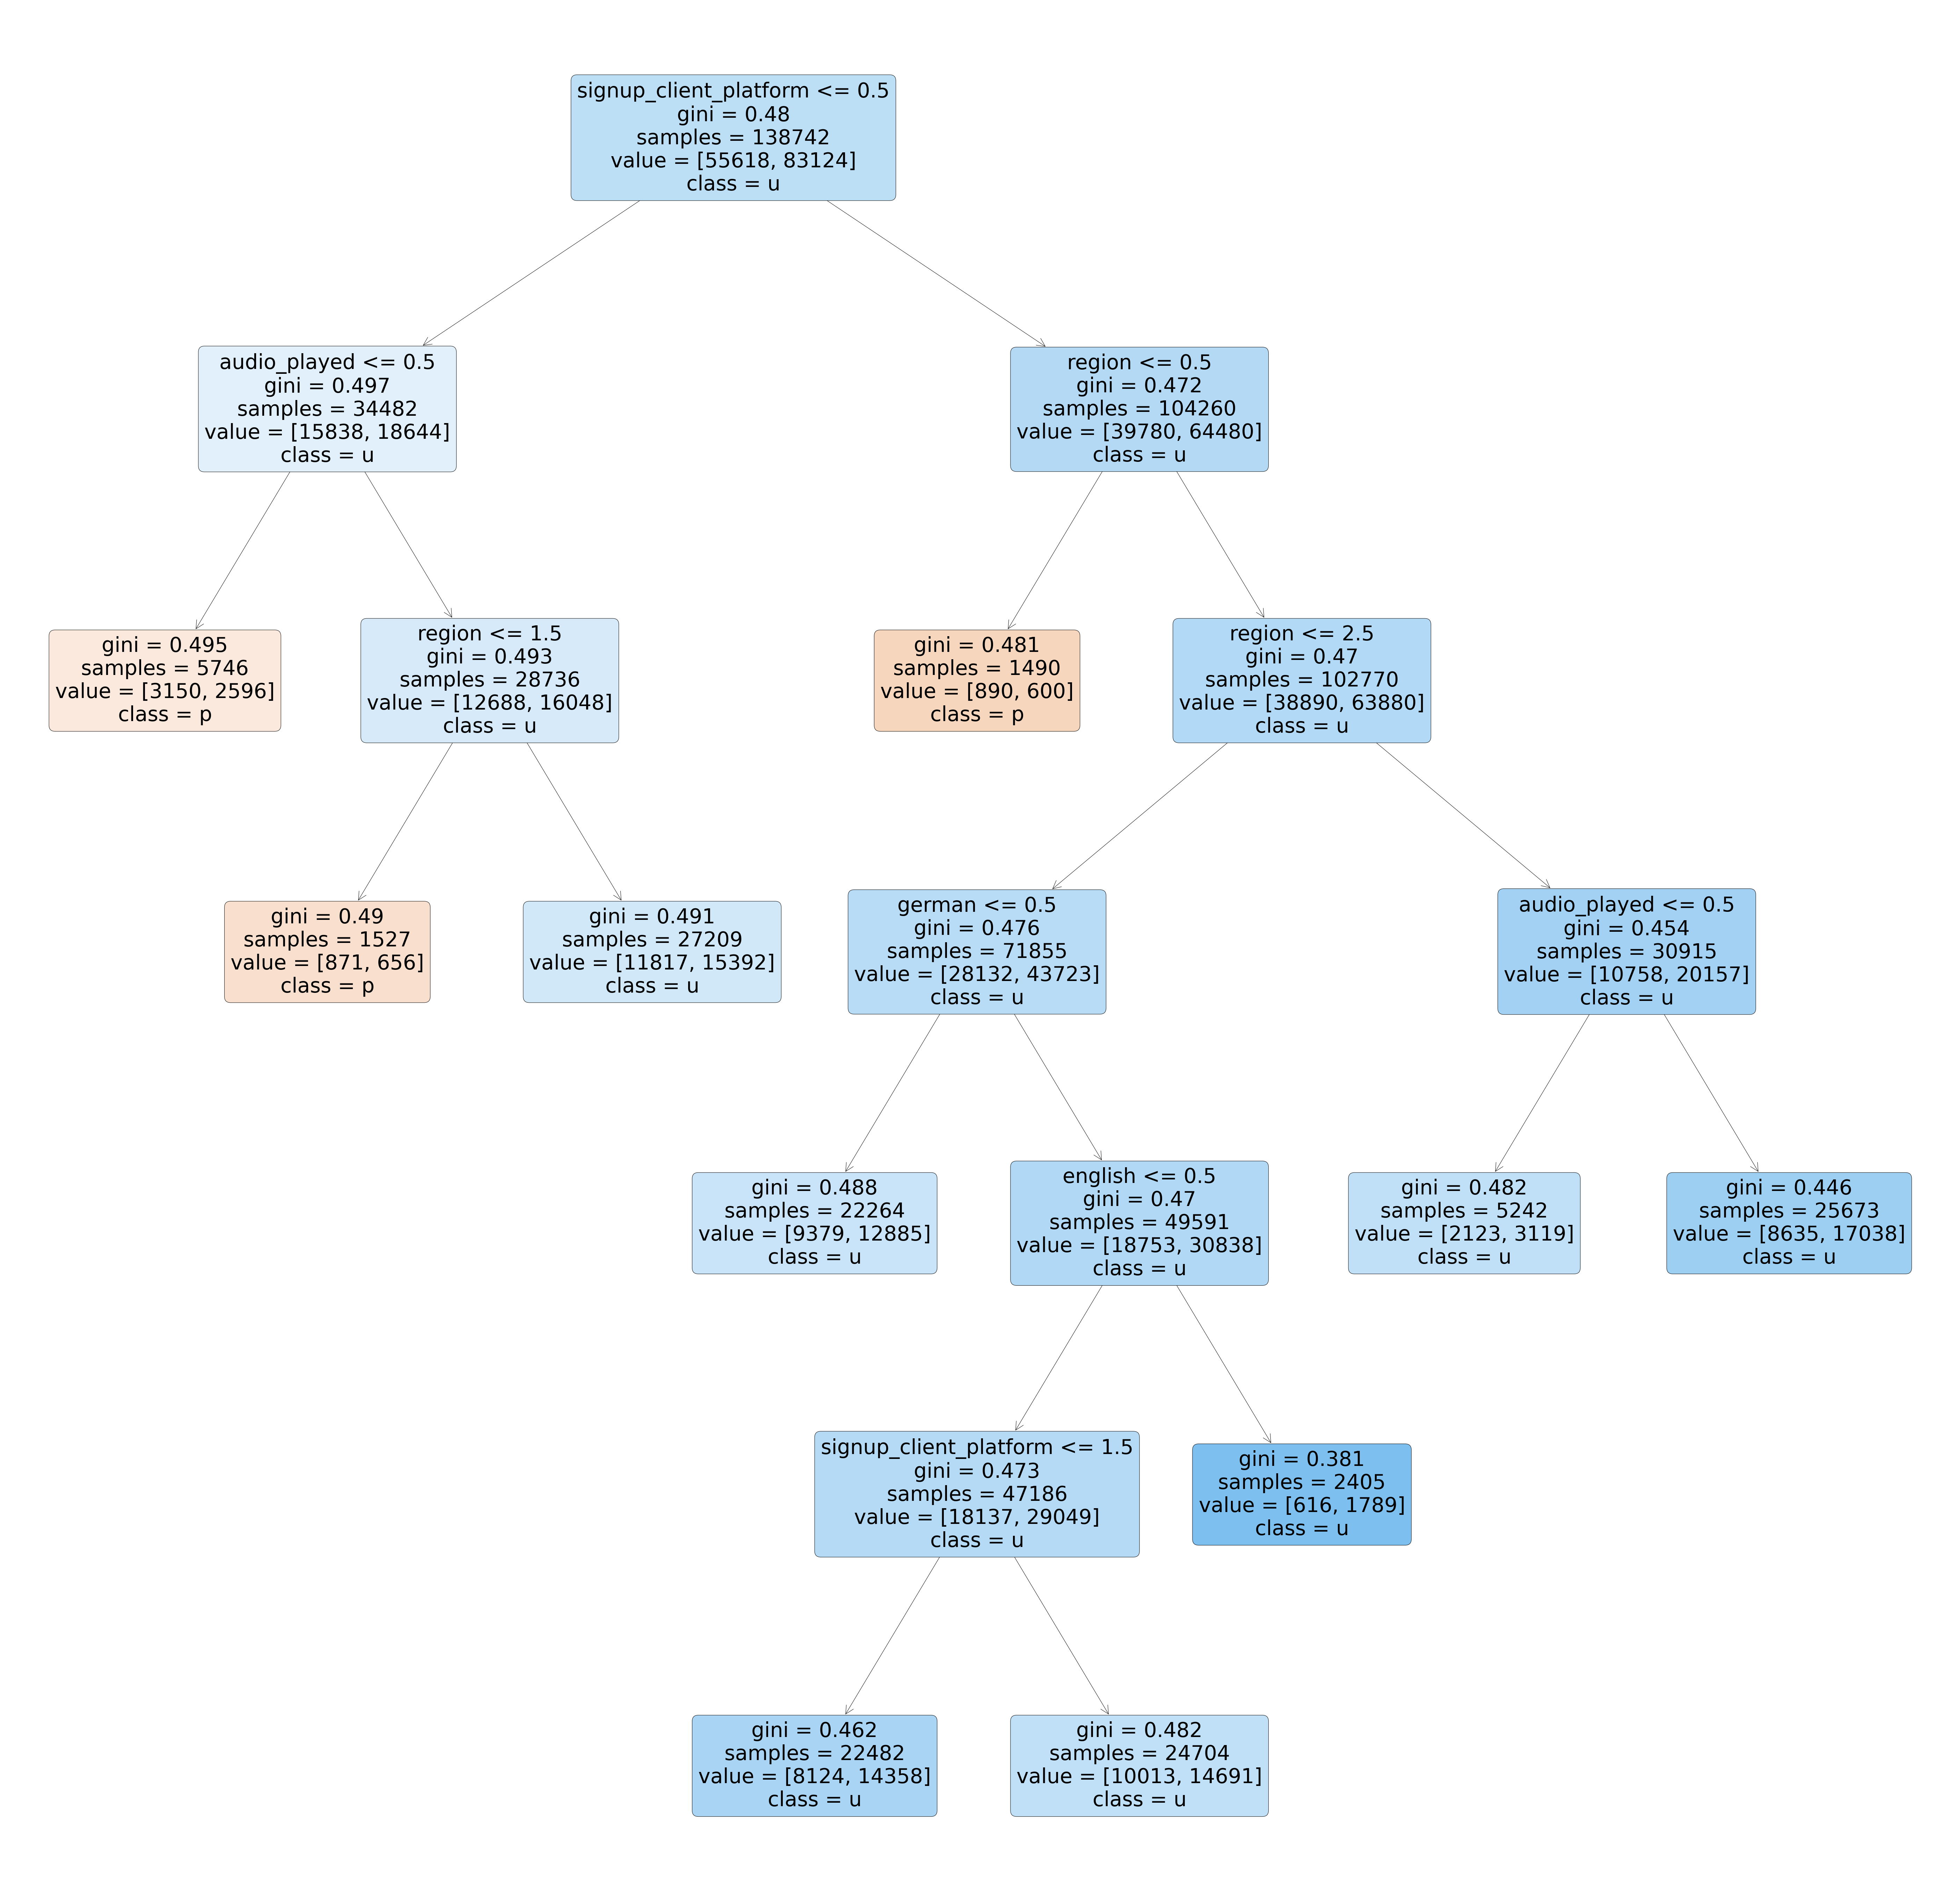

In [702]:
# plotting the data
plt.figure(figsize = (100, 100))
tree.plot_tree(model, filled = True, feature_names = inputs.columns, class_names = "purchase_at", rounded = True )
plt.savefig("sub.pdf")